In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import ticker
rcParams["figure.figsize"] = (10,8)
plt.style.use("science")
import eispac
from glob import glob
import sunpy
from sunpy.io.special import read_genx
import cmcrameri.cm as cmcm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
from scipy import interpolate
from scipy import ndimage
import juanfit
from juanfit import SpectrumFitSingle, SpectrumFitRow
rcParams['axes.labelsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 18
rcParams['figure.figsize'] = [10,10]
rcParams['axes.linewidth'] = 2
from scipy.interpolate import interp1d
import astropy.constants as const


In [3]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [4]:
data_filepath = '../../src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5'
fe_10_184_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_184_536.1c-0.fit.h5"
fe_10_257_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_257_262.4c-1.fit.h5"
fe_11_188_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_11_188_216.2c-0.fit.h5"
fe_11_257_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_11_257_547.4c-3.fit.h5"
fe_12_186_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_12_186_880.1c-0.fit.h5"
fe_12_192_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_12_192_394.1c-0.fit.h5"
fe_12_195_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_12_195_119.2c-0.fit.h5"
fe_14_264_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_14_264_787.1c-0.fit.h5"
si_10_258_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.si_10_258_375.1c-0.fit.h5"
si_10_261_fit_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.si_10_261_058.1c-0.fit.h5"

In [5]:
data_cube_0 = eispac.read_cube(data_filepath,0)
data_cube_1 = eispac.read_cube(data_filepath,1)
data_cube_2 = eispac.read_cube(data_filepath,2)
data_cube_3 = eispac.read_cube(data_filepath,3)

Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.ndda

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


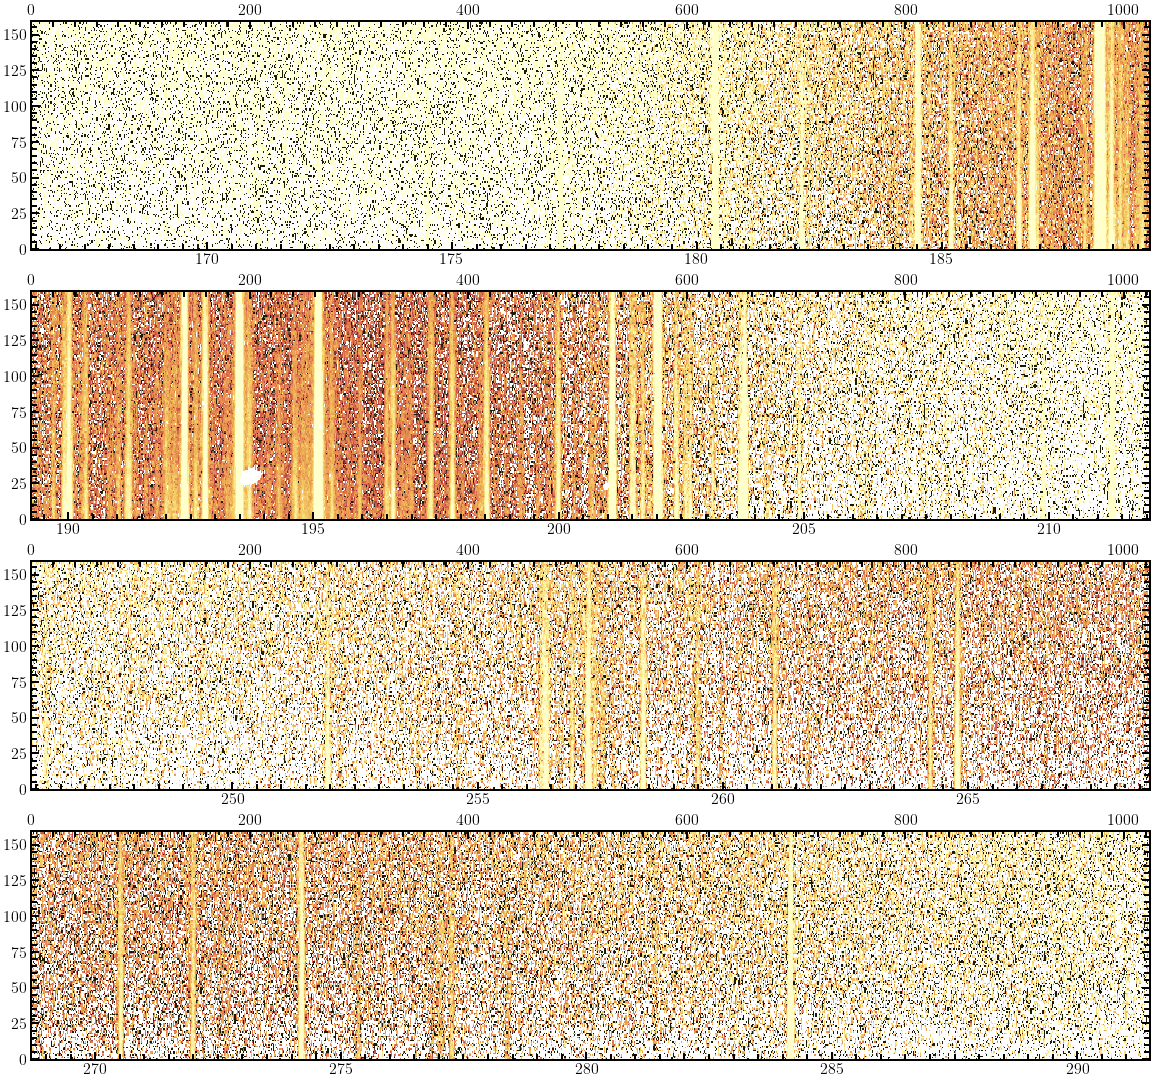

In [6]:
fig, axes = plt.subplots(4,1,figsize=(16,15),constrained_layout=True)

data_cubes = (data_cube_0, data_cube_1, data_cube_2, data_cube_3)
for ii, data_cube_ in enumerate(data_cubes):
    axes[ii].pcolormesh((data_cube_.wavelength)[:,0,:],np.tile(np.arange(160),(1024,1)).T,
                    np.nan_to_num(np.log10(data_cube_.data[:,0,:]),nan=-np.inf),
                    cmap=cmcm.lajolla_r,shading="auto",vmin=0,vmax=2.5)

    ax_pixel = axes[ii].twiny()
    ax_pixel.set_xlim(-0.5,1023.5)
    axes[ii].xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
    ax_pixel.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))

    for ax_ in (axes[ii], ax_pixel):
        ax_.tick_params(labelsize=16)
        ax_.tick_params(which="major",width=2,length=8)
        ax_.tick_params(which="minor",width=2,length=6)

In [7]:
def interp_window_slit_tilt(data,wvl):
    data_shape = data.shape
    data_interp = np.zeros(data_shape)
    for ii in range(data_shape[0]):
        f = interp1d(wvl[ii,:],data[ii,:],kind="cubic",fill_value="extrapolate")
        data_interp[ii,:] = f(wvl[0,:])
    
    return data_interp

In [8]:
data_0_interp = np.zeros_like(data_cube_0.data)
for ii in range(60):
    data_0_interp[:,ii,:] = interp_window_slit_tilt(data_cube_0.data[:,ii,:],data_cube_0.wavelength[:,ii,:])

In [9]:
data_1_interp = np.zeros_like(data_cube_1.data)
for ii in range(60):
    data_1_interp[:,ii,:] = interp_window_slit_tilt(data_cube_1.data[:,ii,:],data_cube_1.wavelength[:,ii,:])

In [10]:
data_2_interp = np.zeros_like(data_cube_2.data)
for ii in range(60):
    data_2_interp[:,ii,:] = interp_window_slit_tilt(data_cube_2.data[:,ii,:],data_cube_2.wavelength[:,ii,:])

In [11]:
data_3_interp = np.zeros_like(data_cube_3.data)
for ii in range(60):
    data_3_interp[:,ii,:] = interp_window_slit_tilt(data_cube_3.data[:,ii,:],data_cube_3.wavelength[:,ii,:])

In [12]:
FeX_184_radcorr_hpw = 1.25465
FeX_184_radcorr_gdz = 1.35044
FeX_257_radcorr_hpw = 1.70066
FeX_257_radcorr_gdz = 2.89774
FeXI_188_radcorr_hpw = 0.979529
FeXI_188_radcorr_gdz = 1.44743
FeXI_257_radcorr_hpw = 1.69542
FeXI_257_radcorr_gdz = 2.87326
FeXII_186_radcorr_hpw = 1.07798
FeXII_186_radcorr_gdz = 1.40138
FeXII_192_radcorr_hpw = 0.833634
FeXII_192_radcorr_gdz = 1.12736
FeXII_195_radcorr_hpw = 0.874023
FeXII_195_radcorr_gdz = 1.00102
SiX_258_radcorr_hpw = 1.68540
SiX_258_radcorr_gdz = 2.79741
SiX_261_radcorr_hpw = 1.73463
SiX_261_radcorr_gdz = 2.67270
FeXIV_264_radcorr_hpw = 2.03844
FeXIV_264_radcorr_gdz = 2.46965

In [13]:
slit_width_aver = np.mean(data_cube_2.meta["slit_width"])

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

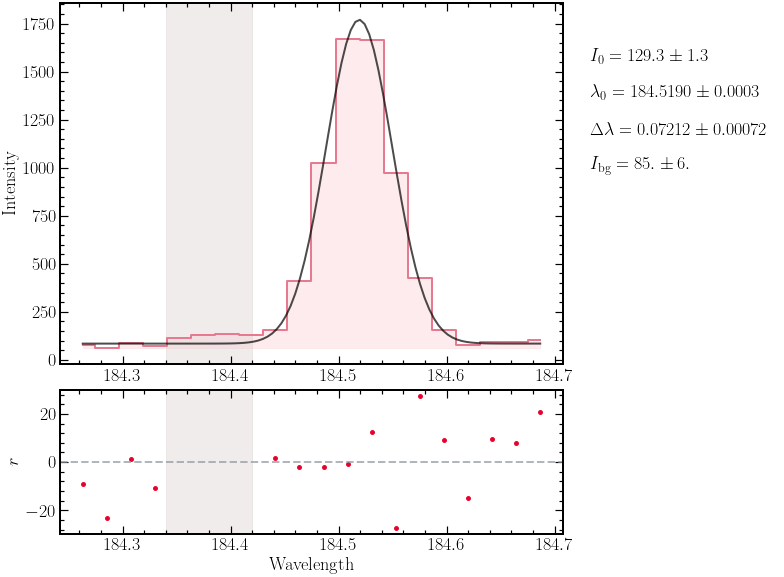

In [14]:
FeX_184_slice = slice(800,820)
data_masked = np.copy(data_0_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeX_184_bin_ = data_masked[:,:,FeX_184_slice]
FeX_184_bin_ = np.nanmean(FeX_184_bin_,axis=(0,1))


FeX_184_bin_fit_model = SpectrumFitSingle(data=FeX_184_bin_, wvl=data_cube_0.wavelength[0,0,FeX_184_slice],
                                        line_number=1,line_wvl_init=[184.5],int_max_init=[1e3],fwhm_init=[0.07],
                                        mask=[[184.34,184.42]])
FeX_184_bin_fit_model.run_lse()
FeX_184_bin_fit_model.plot()

In [17]:
FeX_184_rest_wvl = 184.537
print(np.sqrt(FeX_184_bin_fit_model.fwhm_fit[0]**2 - slit_width_aver**2)/ FeX_184_rest_wvl\
                    *const.c.cgs.value/1e5/np.sqrt(4*np.log(2)))
print(np.sqrt(FeX_184_bin_fit_model.fwhm_fit[0]**2 - 0.062**2)/ FeX_184_rest_wvl\
                    *const.c.cgs.value/1e5/np.sqrt(4*np.log(2)))

19.675765461416077
35.93697382668657


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

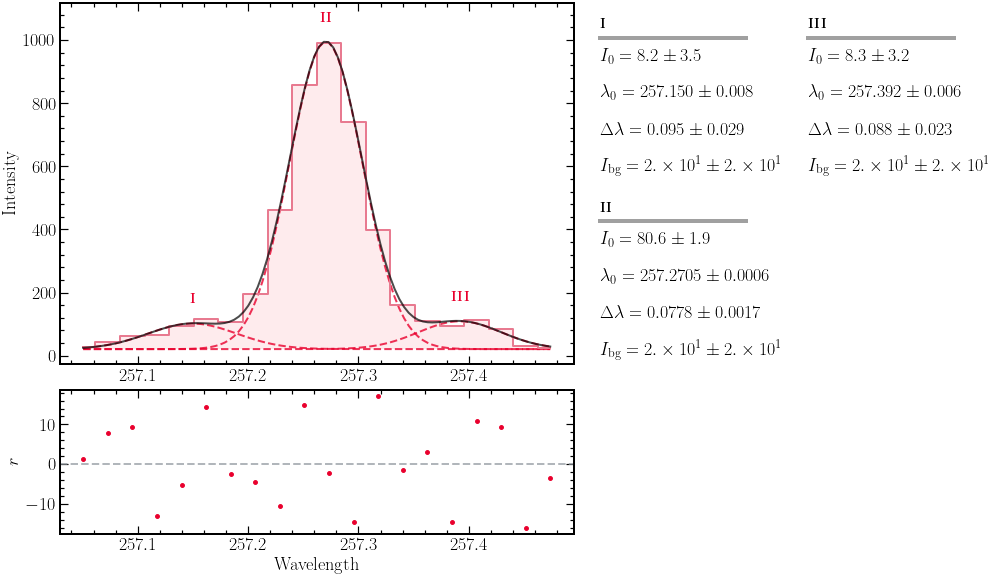

In [19]:
FeX_257_slice = slice(500,520)
data_masked = np.copy(data_2_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeX_257_bin_ = data_masked[:,:,FeX_257_slice]
FeX_257_bin_ = np.nanmean(FeX_257_bin_,axis=(0,1))


FeX_257_bin_fit_model = SpectrumFitSingle(data=FeX_257_bin_, wvl=data_cube_2.wavelength[0,0,FeX_257_slice],
                                        line_number=3,line_wvl_init=[257.15,257.25,257.4],int_max_init=[1e2,1e3,1e2],fwhm_init=[0.07,0.07,0.07],
                                        )
# FeX_257_bin_fit_model.plot(plot_fit=False)
FeX_257_bin_fit_model.run_lse()
FeX_257_bin_fit_model.plot()

In [20]:
def chianti_interp_func(filename,diag="dens"):
    df_ratio = pd.read_csv(filename,skiprows=6,
                names=[diag,"ratio"],sep="\s+",index_col=False,dtype=np.float64)

    interp_func = interpolate.interp1d(df_ratio["ratio"].values, df_ratio[diag].values,kind="cubic",
                                    fill_value="extrapolate")

    return interp_func

In [21]:
FeX_184_257_interp_func_85 = chianti_interp_func("../../sav/CHIANTI/line_ratio/FeX_184_257_temp_85.txt")
FeX_184_257_interp_func_90 = chianti_interp_func("../../sav/CHIANTI/line_ratio/FeX_184_257_temp_90.txt")
FeX_184_257_interp_func_95 = chianti_interp_func("../../sav/CHIANTI/line_ratio/FeX_184_257_temp_95.txt")

In [26]:
print(FeX_184_257_interp_func_85((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_gdz)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_gdz)),
FeX_184_257_interp_func_85((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_hpw)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_hpw)))

5.758998625945613 6.123637397229932


In [27]:
print(FeX_184_257_interp_func_90((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_gdz)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_gdz)),
FeX_184_257_interp_func_90((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_hpw)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_hpw)))

5.576308611823363 5.939012664960814


In [28]:
print(FeX_184_257_interp_func_95((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_gdz)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_gdz)),
FeX_184_257_interp_func_95((FeX_184_bin_fit_model.int_total_fit[0]*FeX_184_radcorr_hpw)/ \
                (FeX_257_bin_fit_model.int_total_fit[1]*FeX_257_radcorr_hpw)))

5.4095775452829535 5.654177690192524


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

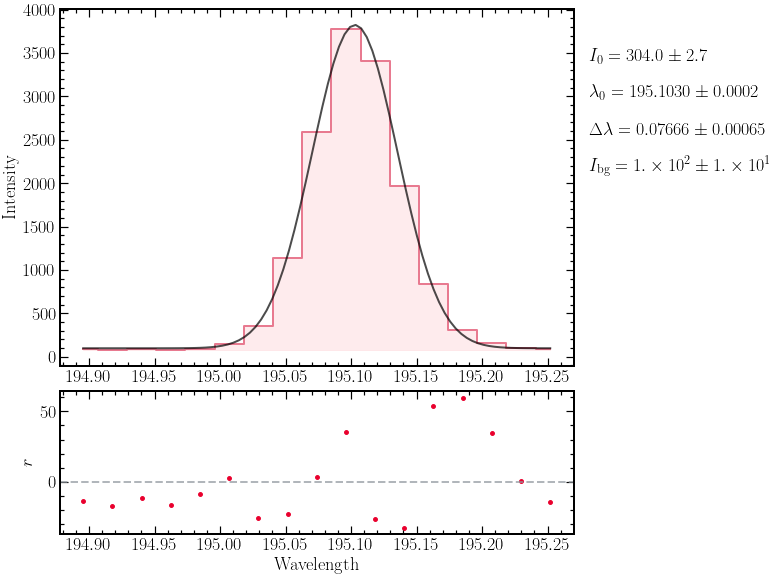

In [31]:
FeXII_195_slice = slice(253,270)
data_masked = np.copy(data_1_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXII_195_bin_ = data_masked[:,:,FeXII_195_slice]
FeXII_195_bin_ = np.nanmean(FeXII_195_bin_,axis=(0,1))


FeXII_195_bin_fit_model = SpectrumFitSingle(data=FeXII_195_bin_, wvl=data_cube_1.wavelength[0,0,FeXII_195_slice],line_number=1,
                                            line_wvl_init=[195.1],int_max_init=[5e3],fwhm_init=[0.08])
FeXII_195_bin_fit_model.run_lse()
FeXII_195_bin_fit_model.plot()

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

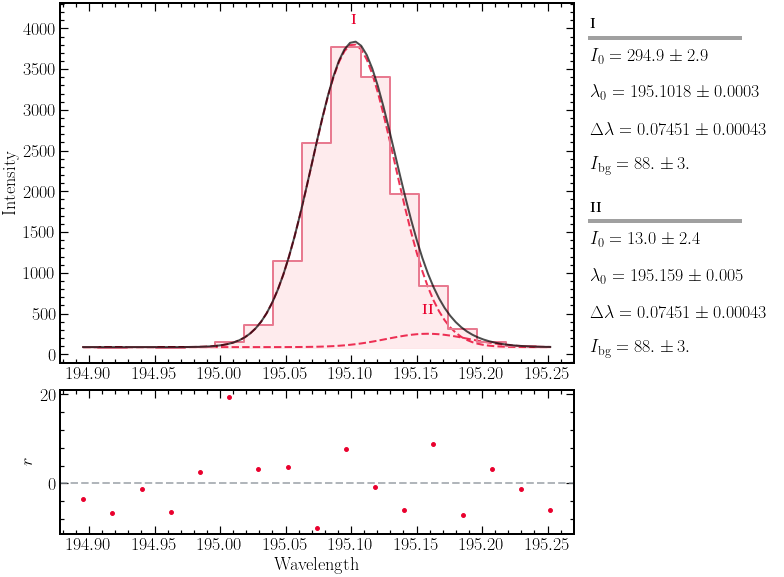

In [32]:
FeXII_195_slice = slice(253,270)
data_masked = np.copy(data_1_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXII_195_bin_ = data_masked[:,:,FeXII_195_slice]
FeXII_195_bin_ = np.nanmean(FeXII_195_bin_,axis=(0,1))


FeXII_195_bin_fit_model_double = SpectrumFitSingle(data=FeXII_195_bin_, wvl=data_cube_1.wavelength[0,0,FeXII_195_slice],line_number=2,
                                            line_wvl_init=[195.1,195.18],int_max_init=[5e3,1e2],fwhm_init=[0.08],same_width=True)
FeXII_195_bin_fit_model_double.run_lse()
FeXII_195_bin_fit_model_double.plot()

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

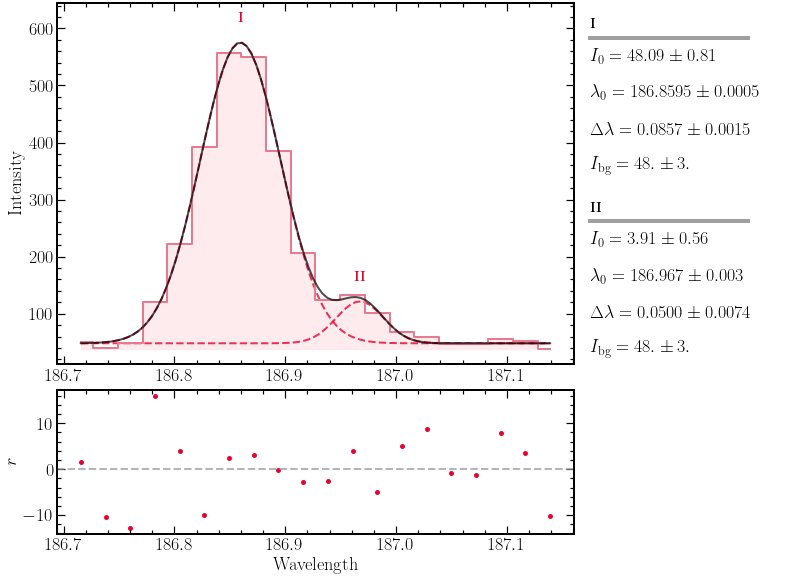

In [36]:
FeXII_186_slice = slice(910,930)
data_masked = np.copy(data_0_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXII_186_bin_ = data_masked[:,:,FeXII_186_slice]
FeXII_186_bin_ = np.nanmean(FeXII_186_bin_,axis=(0,1))


FeXII_186_bin_fit_model = SpectrumFitSingle(data=FeXII_186_bin_, wvl=data_cube_0.wavelength[0,0,FeXII_186_slice],line_number=2,
                                            line_wvl_init=[186.85,186.95],int_max_init=[1e5,1e2],fwhm_init=[0.07,0.07])
FeXII_186_bin_fit_model.run_lse()
FeXII_186_bin_fit_model.plot()

<AxesSubplot:ylabel='Intensity'>

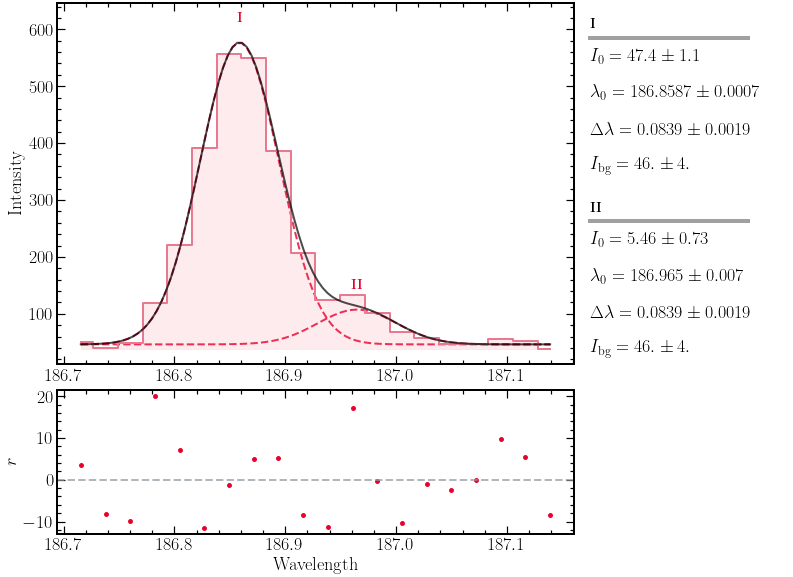

In [38]:
FeXII_186_slice = slice(910,930)
data_masked = np.copy(data_0_interp)
data_masked[np.where(data_masked < -200)] = np.nan
FeXII_186_bin_ = data_masked[:,:,FeXII_186_slice]
FeXII_186_bin_ = np.nanmean(FeXII_186_bin_,axis=(0,1))


FeXII_186_bin_fit_model_sw = SpectrumFitSingle(data=FeXII_186_bin_, wvl=data_cube_0.wavelength[0,0,FeXII_186_slice],line_number=2,
                                            line_wvl_init=[186.85,186.95],int_max_init=[1e5,1e2],fwhm_init=[0.07],same_width=True)
FeXII_186_bin_fit_model_sw.run_lse()
FeXII_186_bin_fit_model_sw.plot()

In [39]:
FeXII_195_186_interp_func = chianti_interp_func("../../sav/CHIANTI/line_ratio/FeXII_195_186_dens.txt")

In [41]:
print(FeXII_195_186_interp_func((FeXII_195_bin_fit_model.int_total_fit[0]*FeXII_195_radcorr_gdz)/ \
                (FeXII_186_bin_fit_model.int_total_fit[0]*FeXII_186_radcorr_gdz)),
FeXII_195_186_interp_func((FeXII_195_bin_fit_model.int_total_fit[0]*FeXII_195_radcorr_hpw)/ \
                (FeXII_186_bin_fit_model.int_total_fit[0]*FeXII_186_radcorr_hpw)))

8.554187386389694 8.45088501691901


In [42]:
print(FeXII_195_186_interp_func((FeXII_195_bin_fit_model_double.int_total_fit[0]*FeXII_195_radcorr_gdz)/ \
                (FeXII_186_bin_fit_model.int_total_fit[0]*FeXII_186_radcorr_gdz)),
FeXII_195_186_interp_func((FeXII_195_bin_fit_model_double.int_total_fit[0]*FeXII_195_radcorr_hpw)/ \
                (FeXII_186_bin_fit_model.int_total_fit[0]*FeXII_186_radcorr_hpw)))

8.579959949956205 8.475075917353298


In [43]:
print(FeXII_195_186_interp_func((FeXII_195_bin_fit_model.int_total_fit[0]*FeXII_195_radcorr_gdz)/ \
                (FeXII_186_bin_fit_model_sw.int_total_fit[0]*FeXII_186_radcorr_gdz)),
FeXII_195_186_interp_func((FeXII_195_bin_fit_model.int_total_fit[0]*FeXII_195_radcorr_hpw)/ \
                (FeXII_186_bin_fit_model_sw.int_total_fit[0]*FeXII_186_radcorr_hpw)))

8.541579021453598 8.439044724485695


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

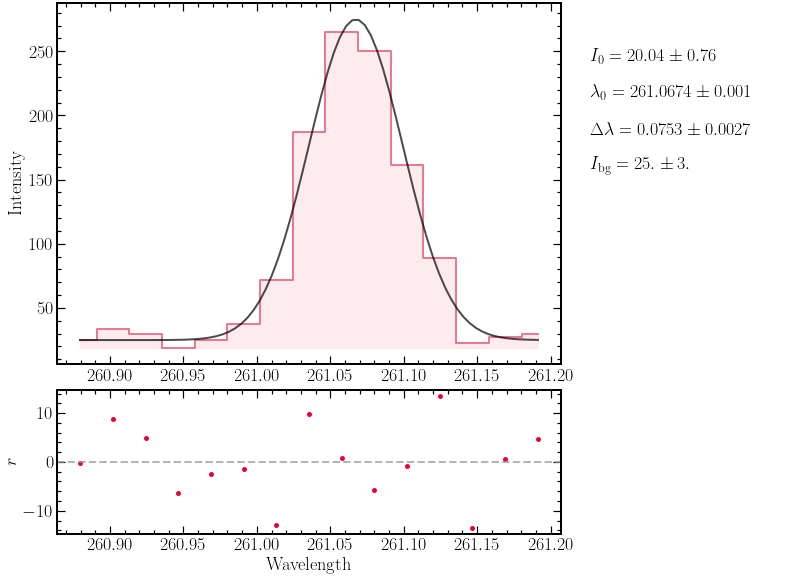

In [45]:
SiX_261_slice = slice(672,687)
data_masked = np.copy(data_2_interp)
data_masked[np.where(data_masked < -200)] = np.nan
SiX_261_bin_ = data_masked[:,:,SiX_261_slice]
SiX_261_bin_ = np.nanmean(SiX_261_bin_,axis=(0,1))


SiX_261_bin_fit_model = SpectrumFitSingle(data=SiX_261_bin_, wvl=data_cube_2.wavelength[0,0,SiX_261_slice],line_number=1,
                                            line_wvl_init=[261.06],int_max_init=[3e2],fwhm_init=[0.08])
SiX_261_bin_fit_model.run_lse()
SiX_261_bin_fit_model.plot()

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

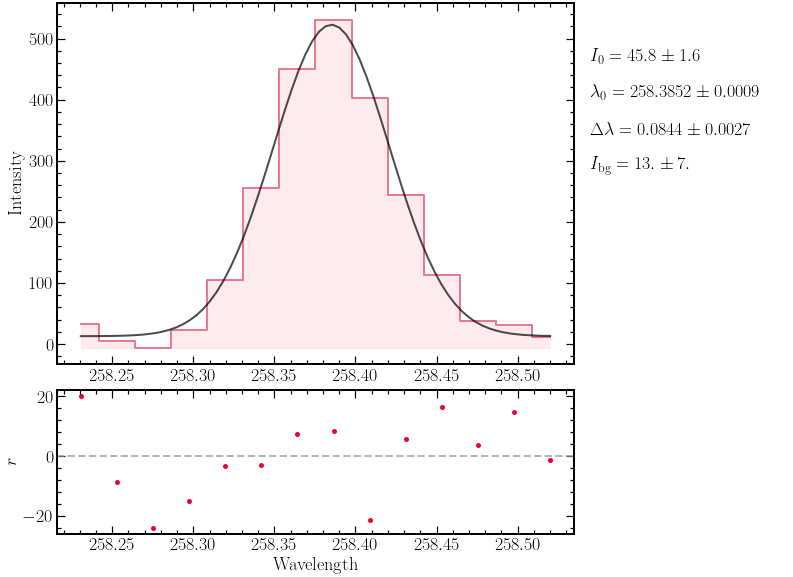

In [46]:
SiX_258_slice = slice(553,567)
data_masked = np.copy(data_2_interp)
data_masked[np.where(data_masked < -200)] = np.nan
SiX_258_bin_ = data_masked[:,:,SiX_258_slice]
SiX_258_bin_ = np.nanmean(SiX_258_bin_,axis=(0,1))


SiX_258_bin_fit_model = SpectrumFitSingle(data=SiX_258_bin_, wvl=data_cube_2.wavelength[0,0,SiX_258_slice],line_number=1,
                                            line_wvl_init=[258.38],int_max_init=[3e2],fwhm_init=[0.08])
SiX_258_bin_fit_model.run_lse()
SiX_258_bin_fit_model.plot()

In [47]:
SiX_261_258_interp_func = chianti_interp_func("../../sav/CHIANTI/line_ratio/SiX_261_258_dens.txt")

In [48]:
print(SiX_261_258_interp_func((SiX_261_bin_fit_model.int_total_fit[0]*SiX_261_radcorr_gdz)/ \
                (SiX_258_bin_fit_model.int_total_fit[0]*SiX_258_radcorr_gdz)),
SiX_261_258_interp_func((SiX_261_bin_fit_model.int_total_fit[0]*SiX_261_radcorr_hpw)/ \
                (SiX_258_bin_fit_model.int_total_fit[0]*SiX_258_radcorr_hpw)))

8.753068369207611 8.617710220040202
